# Implementation Questions

In [1]:
import pandas
from sklearn.model_selection import train_test_split
import numpy
import torch
import matplotlib.pyplot as plt
import math
from torchvision import datasets, transforms

device = 'cuda:0'

## Question 1

### a)
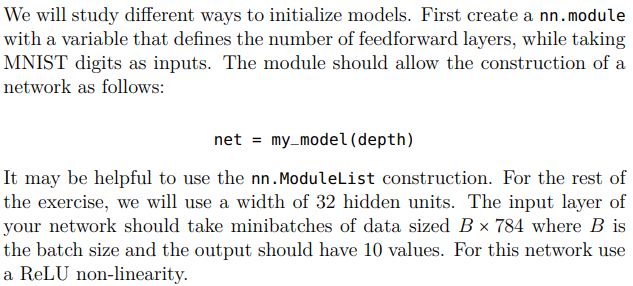

In [2]:
class mnist_neural_net(torch.nn.Module):
    def __init__(_self, _depth):
        super().__init__()
        _self.in_layer = torch.nn.Linear(784, 32)
        _self.activation_func = torch.nn.ReLU()
        _self.linears = torch.nn.ModuleList([torch.nn.Linear(32, 32) for i in range(_depth)])
        _self.out_layer = torch.nn.Linear(32, 10)


    def forward(_self, data):
        x = _self.in_layer(data)
        x = _self.activation_func(x)
        x.retain_grad()
        for i, layer in enumerate(_self.linears):
            x = _self.linears[i](x)
            x = _self.activation_func(x)
            x.retain_grad()

        return _self.out_layer(x)

### b) 
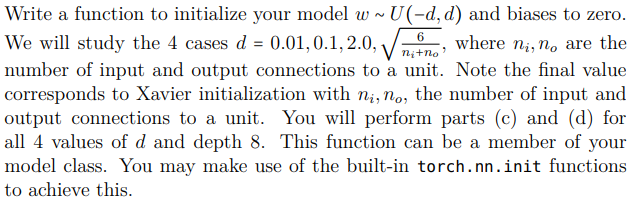

In [3]:
def init_mnist_net_weights(_network, _d, _special_case=False):
    for name, parameter in _network.named_parameters():
        if "bias" in name:
            parameter.data = torch.zeros(size=parameter.data.shape)

            continue

        if _special_case:
            value = math.sqrt(6 / (parameter.data.shape[0] + parameter.data.shape[1]))
            parameter.data = torch.nn.init.uniform_(parameter.data, -value, value)
        else:
            parameter.data = torch.nn.init.uniform_(parameter.data, -_d, _d)
            


d = [0.01, .1, 2.0, 0.0]

depth = 8

### c)
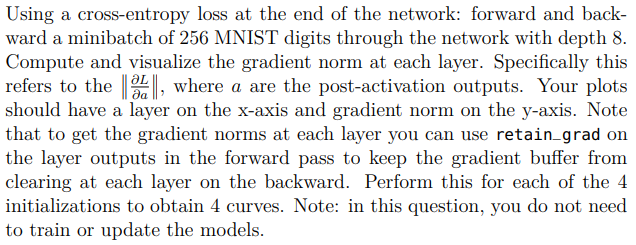

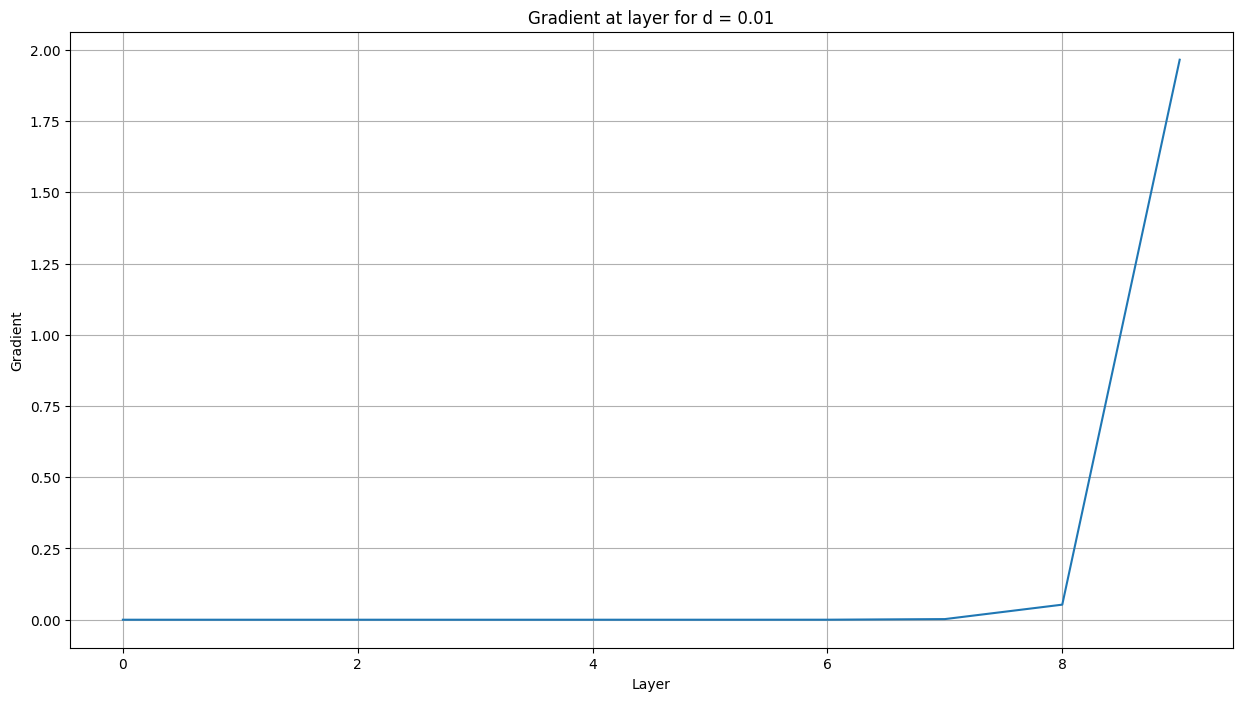

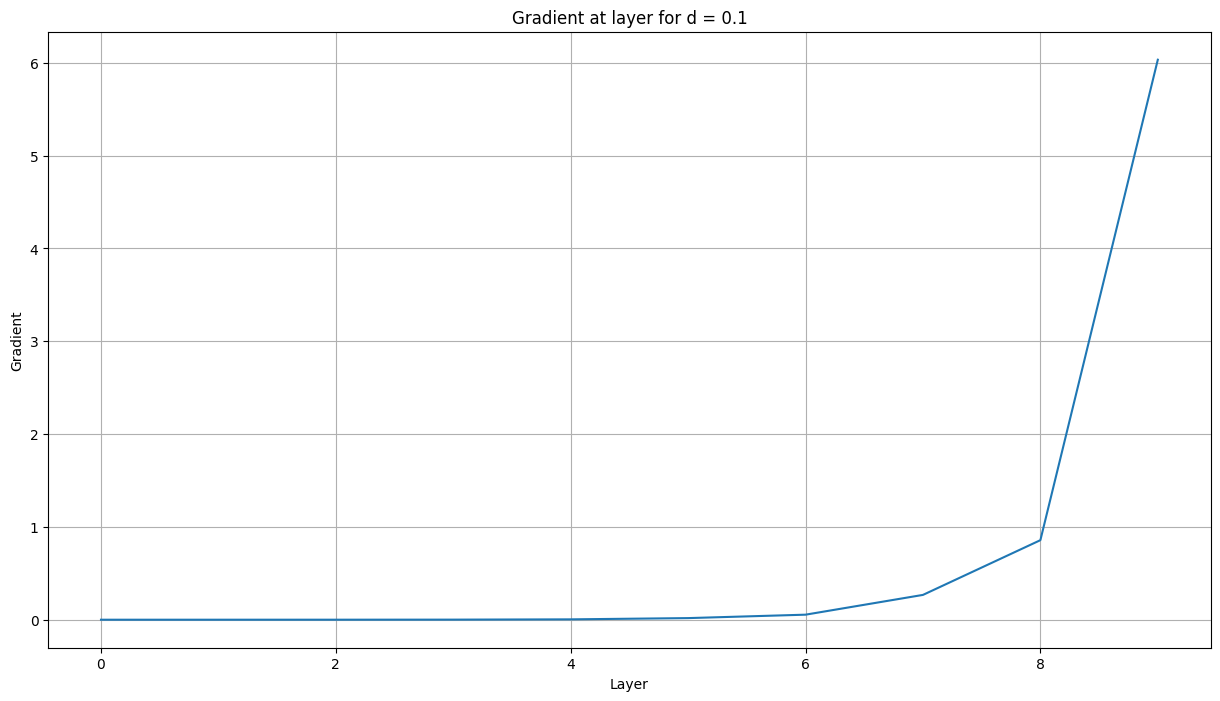

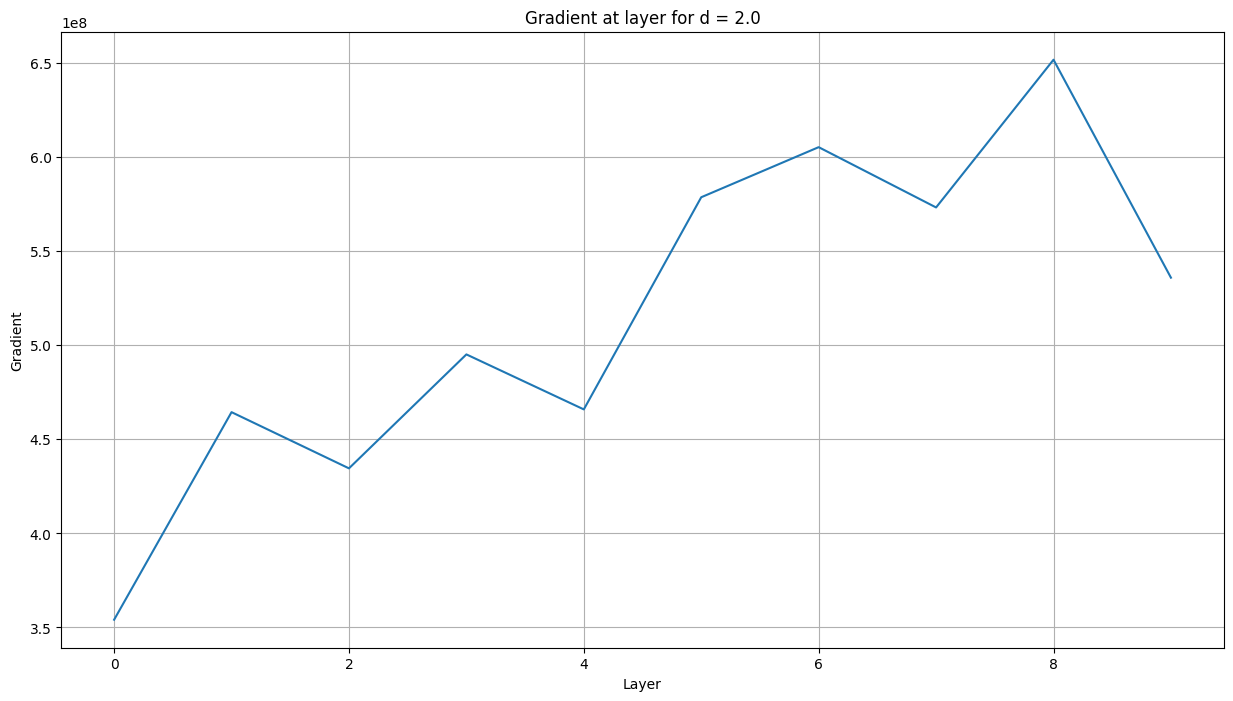

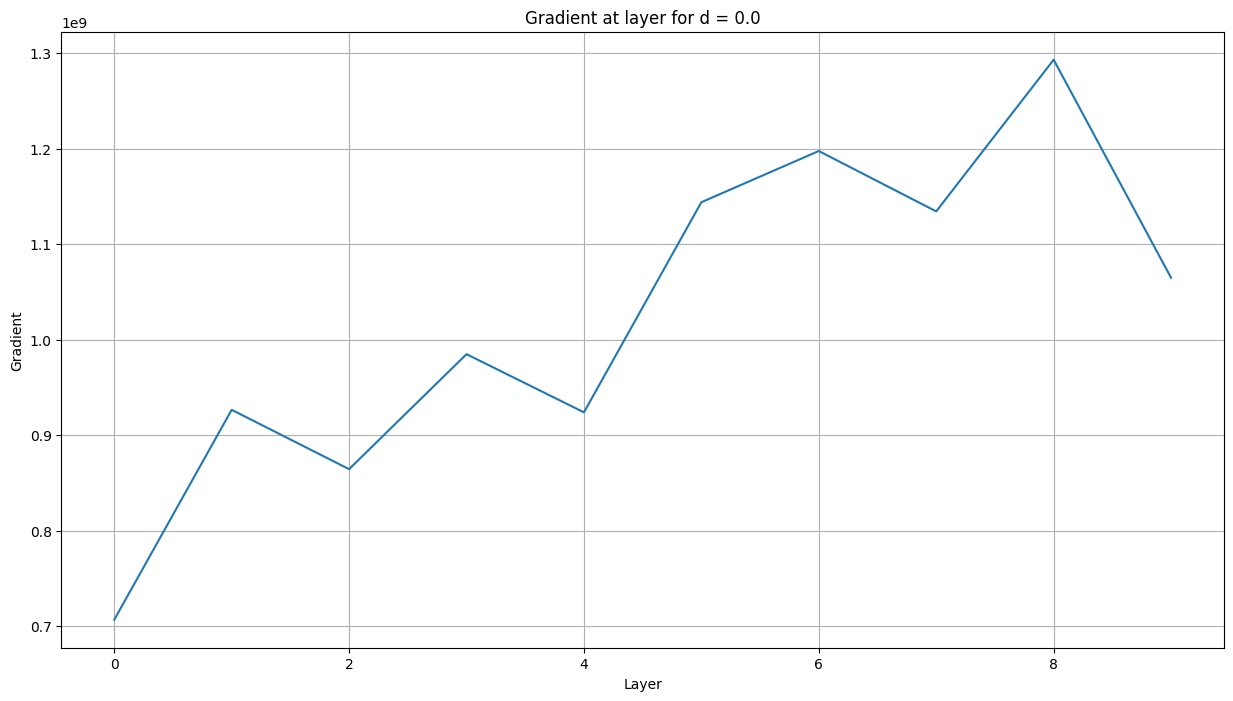

In [4]:
import torch.utils
import torch.utils.data

mnist_train_dataset = datasets.MNIST('../data', train=True, download=True, transform=transforms.ToTensor())
train_loader = torch.utils.data.DataLoader(mnist_train_dataset,
                                           batch_size=256,
                                           shuffle=True,
                                           drop_last=True)

_mnist_neural_net = mnist_neural_net(depth)
_mnist_neural_net.train()

mnist_loss = torch.nn.CrossEntropyLoss(reduction="mean")

for i in range(len(d)):
    fig, ax = plt.subplots(figsize=(15, 8))

    if d[i] == 0.0:
        init_mnist_net_weights(_mnist_neural_net, d[i], True)
    else:
        init_mnist_net_weights(_mnist_neural_net, d[i])

    _mnist_neural_net.to(device)

    layer_norm = [None for i in range(depth + 2)]

    batch_count = 0

    for (data, target) in train_loader:
        data = data.to(device)
        target = target.to(device)

        predictions = _mnist_neural_net.forward(data.view(-1, 28*28))
        loss = mnist_loss(predictions, target)
        loss.backward()

        batch_layer_dict_list = [None for i in range(depth + 2)]

        layer_count = 0

        for name, parameter in _mnist_neural_net.named_parameters():
            name_split = name.split('.')
            trimmed_name = name_split[0]
            if "linears" in name_split[0]:
                trimmed_name = f"{name_split[0]}{name_split[1]}"

            if batch_layer_dict_list[layer_count] == None:
                batch_layer_dict_list[layer_count] = { trimmed_name: torch.norm(parameter.grad).item() }
            else:
                if layer_norm[layer_count] == None:
                    layer_norm[layer_count] = batch_layer_dict_list[layer_count][trimmed_name] + torch.norm(parameter.grad).item()
                else:
                    layer_norm[layer_count] += batch_layer_dict_list[layer_count][trimmed_name] + torch.norm(parameter.grad).item()

                layer_count += 1

        batch_count += 1

    # plot the gradient layers here
    mean_norms = []
    for j in range(len(layer_norm)):
        mean_norms.append(layer_norm[j] / batch_count)

    ax.plot(numpy.arange(len(mean_norms)), mean_norms)

    # Show plot of layer gradients at the end of an init trial
    ax.set_xlabel("Layer")
    ax.set_ylabel("Gradient")
    ax.set_title(f"Gradient at layer for d = {d[i]}")
    ax.grid()
    
    plt.show()

### d)
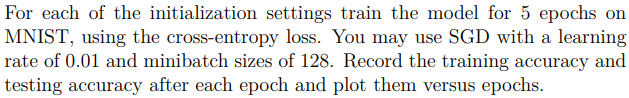

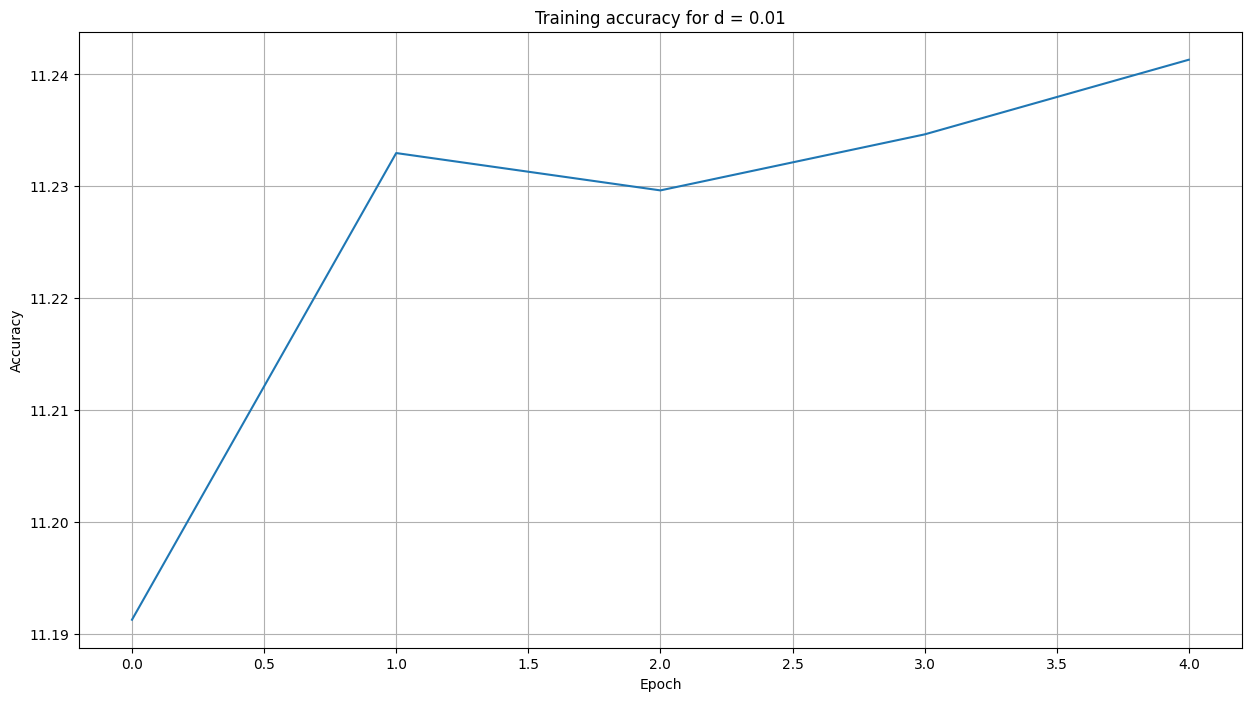

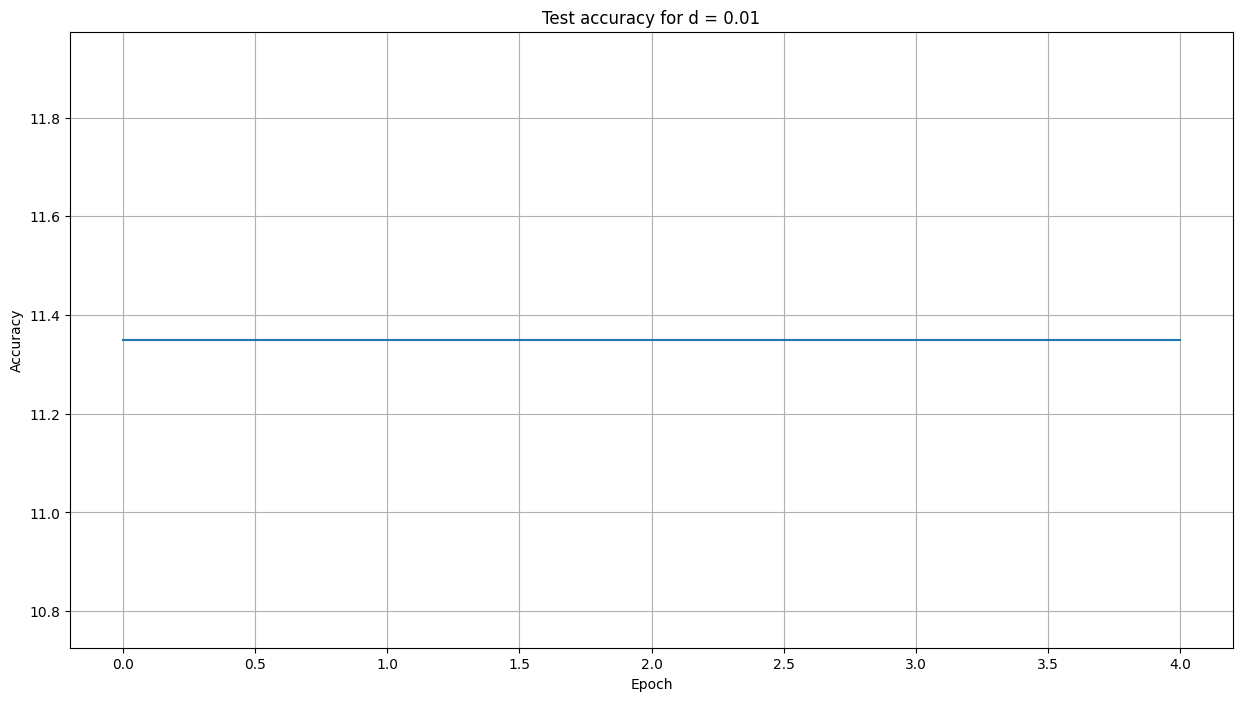

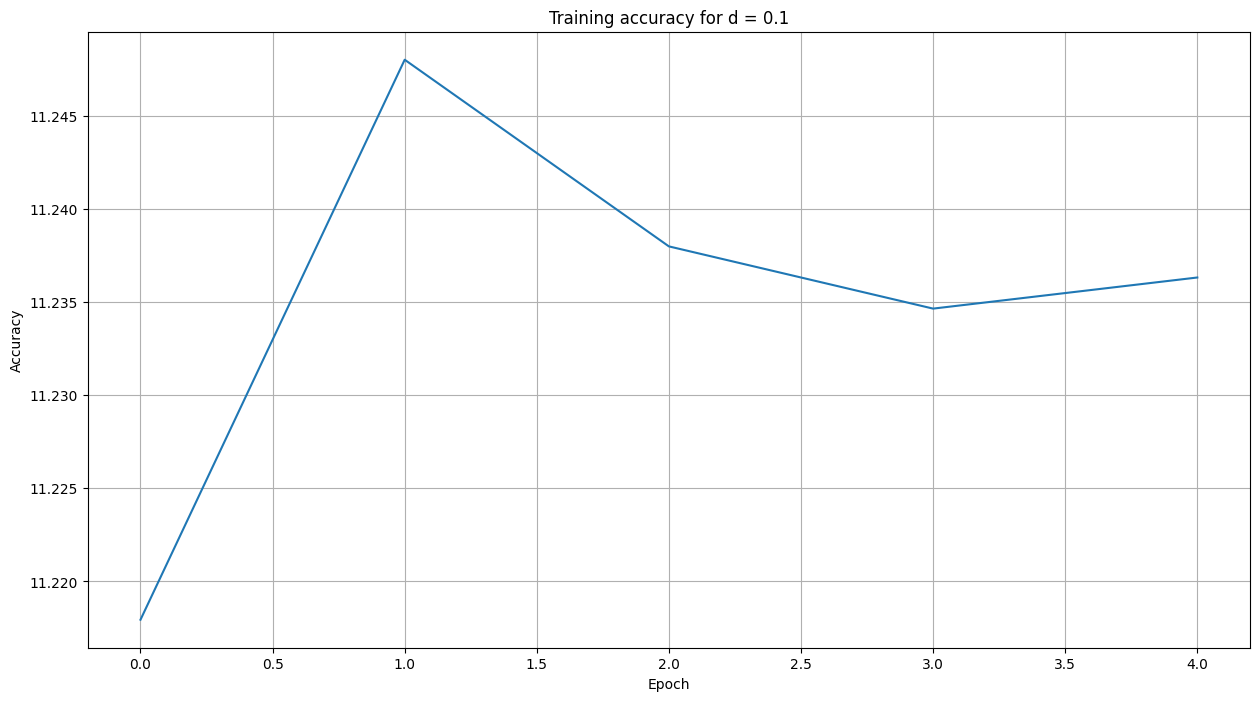

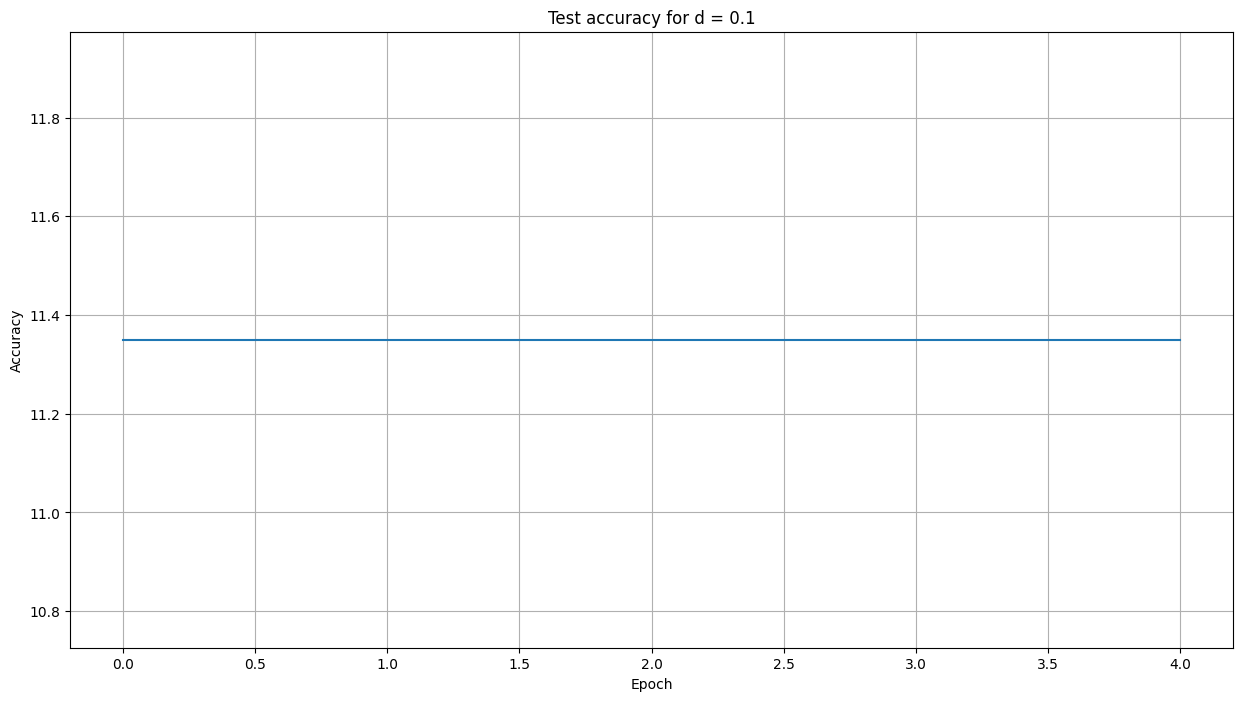

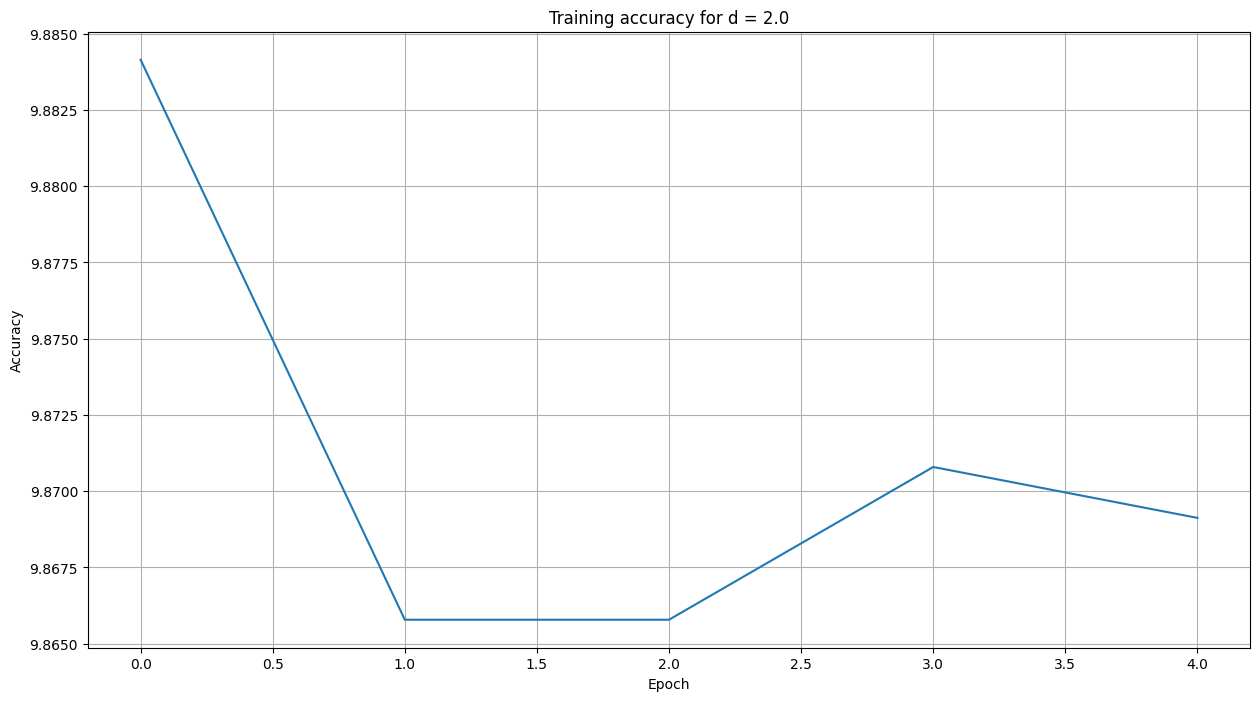

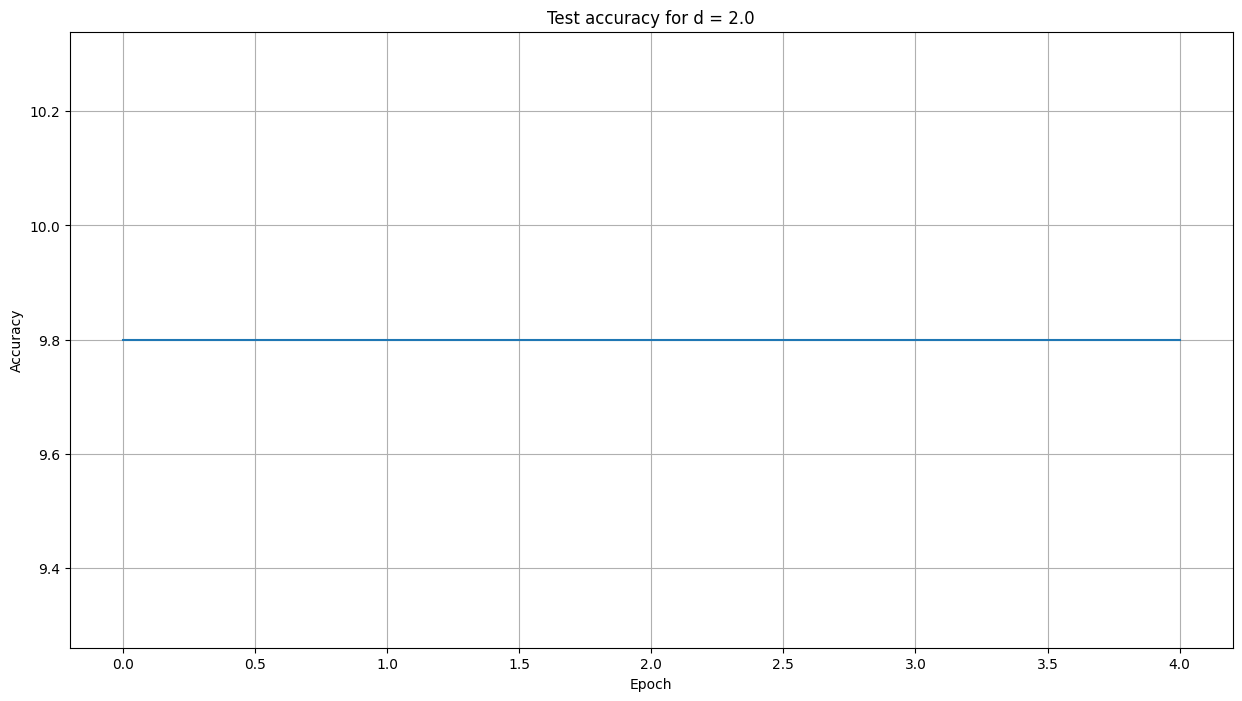

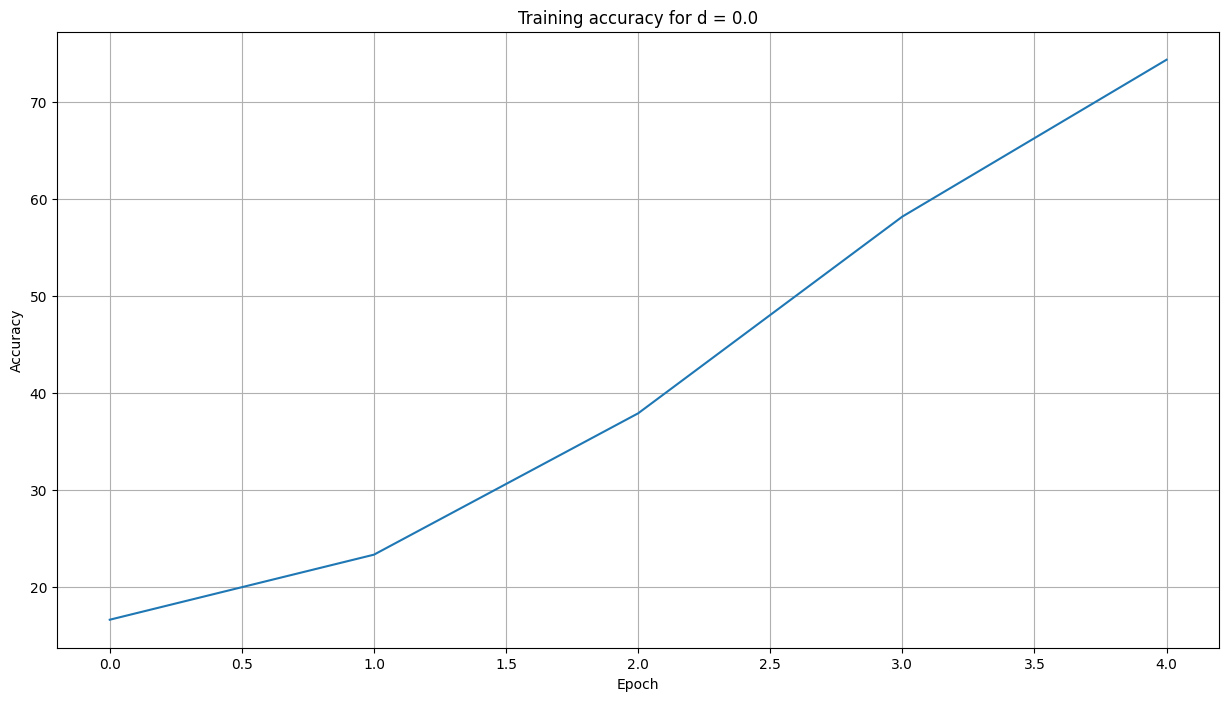

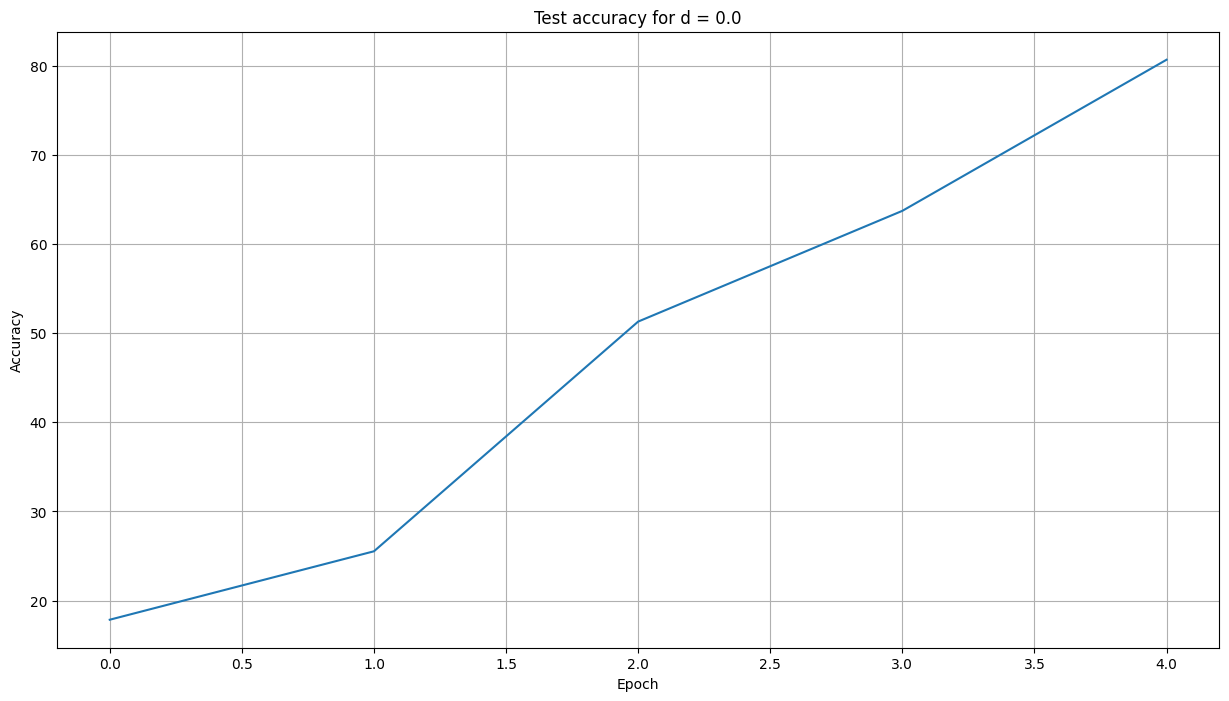

In [5]:
mnist_train_dataset_2 = datasets.MNIST('../data', train=True, download=True, transform=transforms.ToTensor())
train_loader_2 = torch.utils.data.DataLoader(mnist_train_dataset_2,
                                           batch_size=128,
                                           shuffle=True,
                                           drop_last=True)

mnist_test_dataset = datasets.MNIST('../data', train=False, download=True, transform=transforms.ToTensor())
mnist_test_loader = torch.utils.data.DataLoader(mnist_test_dataset,
                                           batch_size=len(mnist_test_dataset),
                                           shuffle=True,
                                           drop_last=True)

for i in range(len(d)):
    if d[i] == 0.0:
        init_mnist_net_weights(_mnist_neural_net, d[i], True)
    else:
        init_mnist_net_weights(_mnist_neural_net, d[i])

    _mnist_neural_net.to(device)

    mnist_num_epochs = 5

    mnist_learning_rate = 0.01

    mnsist_loss = torch.nn.CrossEntropyLoss(reduction="mean")

    mnist_optimizer = torch.optim.SGD(_mnist_neural_net.parameters(), lr=mnist_learning_rate)

    mnist_train_accuracies = []

    mnist_test_accuracies = []

    fig, train_acc = plt.subplots(figsize=(15, 8))

    fig, test_acc = plt.subplots(figsize=(15, 8))

    for epoch in range(mnist_num_epochs):
        _mnist_neural_net.train()

        batch_train_acc = []

        for (data, target) in train_loader_2:
            data = data.to(device)
            target = target.to(device)

            mnist_optimizer.zero_grad()

            predictions = _mnist_neural_net.forward(data.view(-1, 28*28))
            loss = mnist_loss(predictions, target)
            loss.backward()

            mnist_optimizer.step()

            batch_train_acc.append(((torch.argmax(torch.softmax(predictions, dim=1), dim=1) == target).sum() / len(target)).item() * 100)

        mnist_train_accuracies.append(sum(batch_train_acc) / len(batch_train_acc))
        
        _mnist_neural_net.eval()

        for (data, target) in mnist_test_loader:
            data = data.to(device)
            target = target.to(device)

            predictions = _mnist_neural_net.forward(data.view(-1, 28*28))

            mnist_test_accuracies.append(((torch.argmax(torch.softmax(predictions, dim=1), dim=1) == target).sum() / len(target)).item() * 100)
    
    train_acc.plot(numpy.arange(len(mnist_train_accuracies)), mnist_train_accuracies)
    train_acc.set_xlabel("Epoch")
    train_acc.set_ylabel("Accuracy")
    train_acc.set_title(f"Training accuracy for d = {d[i]}")
    train_acc.grid()

    test_acc.plot(numpy.arange(len(mnist_test_accuracies)), mnist_test_accuracies)
    test_acc.set_xlabel("Epoch")
    test_acc.set_ylabel("Accuracy")
    test_acc.set_title(f"Test accuracy for d = {d[i]}")
    test_acc.grid()

    plt.show()

### e)
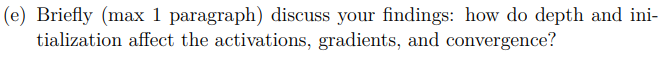

- The effect of improper weight initialization can either cause the vanishing or exploding gradient effect. This means that when performing backpropagtion for the weight gradients, weights found in earlier layers may have either incredibly small or large gradient values. This in turn can cause either inconsequential updates towards the local minima of the function space or enormous updates that overshoot the minima.
- Additionally, this can cause convergence toward the minima to be difficult to acheive.

## Question 2
### In the previous assignment, you developed a machine learning model to predict health insurance prices for individuals based on attributes such as age, sex, region, etc, based on this dataset. In this task, you are required to design and train a neural network using PyTorch to tackle this regression problem.

#### a) Load and split your dataset into train and test sets with a 7:3 ratio using methods from PyTorch.

In [4]:
health_insurance_premiums = pandas.read_csv("Health Insurance Dataset(insurance).csv")
health_insurance_premiums.loc[health_insurance_premiums['sex'] == "male", 'sex'] = 1
health_insurance_premiums.loc[health_insurance_premiums['sex'] == "female", 'sex'] = 2
health_insurance_premiums.loc[health_insurance_premiums['smoker'] == "yes", 'smoker'] = 1
health_insurance_premiums.loc[health_insurance_premiums['smoker'] == "no", 'smoker'] = 0
health_insurance_premiums.loc[health_insurance_premiums['region'] == "southwest", 'region'] = 1
health_insurance_premiums.loc[health_insurance_premiums['region'] == "southeast", 'region'] = 2
health_insurance_premiums.loc[health_insurance_premiums['region'] == "northwest", 'region'] = 3
health_insurance_premiums.loc[health_insurance_premiums['region'] == "northeast", 'region'] = 4
health_insurance_premiums = health_insurance_premiums.astype(float)

health_train_data, health_test_data, health_train_target, health_test_target = train_test_split(health_insurance_premiums[['age', 'sex', 'bmi', 'children', 'smoker', 'region']].to_numpy(),
                                                                                                health_insurance_premiums.charges.to_numpy(),
                                                                                                test_size=0.3,
                                                                                                random_state=42)
health_train_data = torch.tensor(health_train_data, dtype=torch.float32)
health_test_data = torch.tensor(health_test_data, dtype=torch.float32)
health_train_target = torch.tensor(health_train_target, dtype=torch.float32)
health_test_target = torch.tensor(health_test_target, dtype=torch.float32)

#### b) Implement and train your neural network. Note and plot the performance in terms of batch vs loss across 100 epochs. Analyze the Mean Squared Error (MSE) and Mean Average Error (MAE) on the test set.

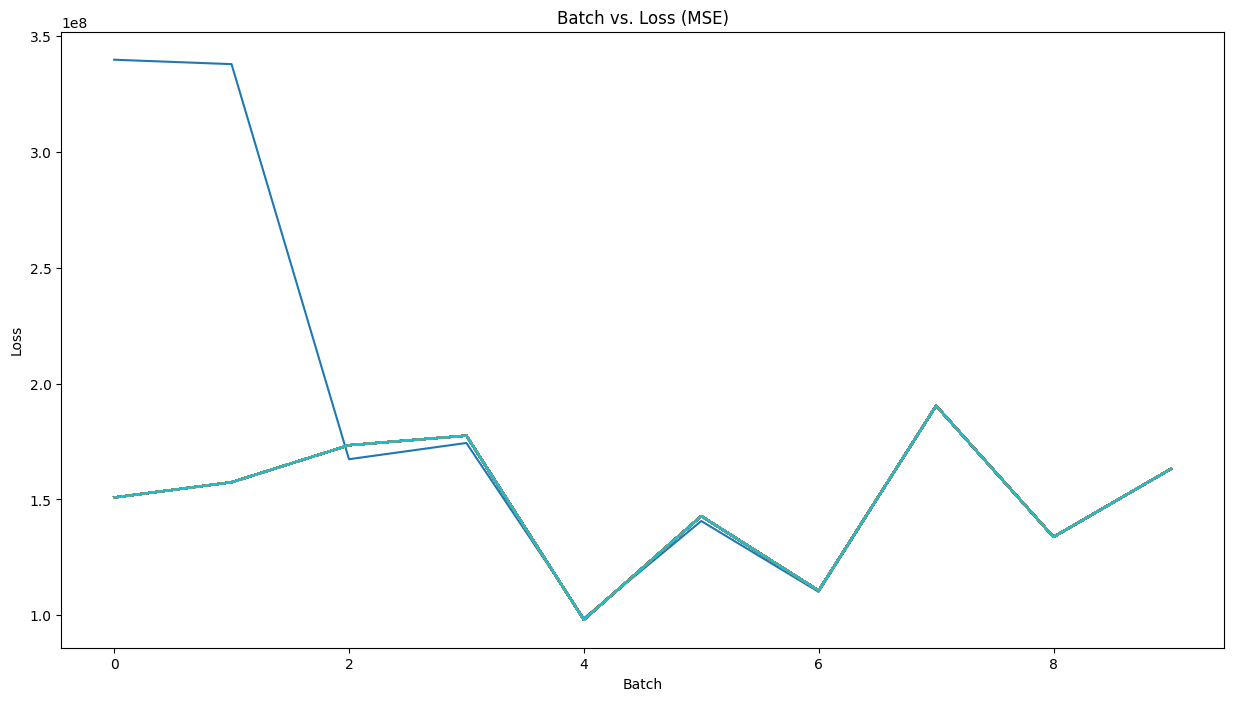

Test loss: 147687152.00
Test L1 loss: 9459.88


In [5]:
torch.manual_seed(0)

layer_one_size = health_train_data.shape[1] * 10
layer_two_size = layer_one_size * 2

health_neural_net = torch.nn.Sequential(
    torch.nn.Linear(health_train_data.shape[1], layer_one_size),
    torch.nn.Tanh(),
    torch.nn.Linear(layer_one_size, layer_two_size),
    torch.nn.Tanh(),
    torch.nn.Linear(layer_two_size, layer_two_size),
    torch.nn.Tanh(),
    torch.nn.Linear(layer_two_size, layer_one_size),
    torch.nn.Tanh(),
    torch.nn.Linear(layer_one_size, 1),
)
health_neural_net.train()

health_num_epochs = 100

health_batch_size = 100

health_learning_rate = 0.01

health_loss = torch.nn.MSELoss(reduction="mean")

health_optimizer = torch.optim.SGD(health_neural_net.parameters(), lr=health_learning_rate)

health_training_losses = []

fig, loss_ax = plt.subplots(figsize=(15, 8))

for epoch in range(health_num_epochs):
    for i in range(0, len(health_train_data), health_batch_size):
        X_data = health_train_data[i:i+health_batch_size]

        y_value = health_train_target[i:i+health_batch_size]

        health_optimizer.zero_grad()

        loss = health_loss(health_neural_net(X_data).view(-1), y_value)
        loss.backward()

        health_optimizer.step()

        health_training_losses.append(loss.item())

    loss_ax.plot(numpy.arange(len(health_training_losses)), health_training_losses, label=f"Epoch {epoch}")
    loss_ax.set_xlabel("Batch")
    loss_ax.set_ylabel("Loss")
    loss_ax.set_title(f"Batch vs. Loss (MSE)")
    loss_ax.grid()

    health_training_losses.clear()

plt.show()

health_neural_net.eval()

health_test_predictions = health_neural_net(health_test_data).view(-1)
health_test_loss = health_loss(health_test_predictions, health_test_target)

health_mae_loss = torch.nn.functional.l1_loss(health_test_predictions, health_test_target)

print(f"Test loss: {health_test_loss:.2f}\nTest L1 loss: {health_mae_loss:.2f}")

#### c) It is time to fine-tune your model with the aim of enhancing its performance. Implement a grid search considering the learning rate and batch size parameters. Try variations of learning rates (i.e. 0.1, 0.01, 0.001, 0.0001, etc) and batch sizes (8, 16, 32, 64, etc). Compare the results in terms of training curves and testing performance.

In [6]:
learning_rates = [0.2, 0.1, .05, .025, 0.01, 0.001]

batch_sizes = [2**i for i in range(3, 9)]

health_train_data, health_val_data, health_train_target, health_val_target = train_test_split(health_train_data,
                                                                                                health_train_target,
                                                                                                test_size=0.2,
                                                                                                random_state=42)

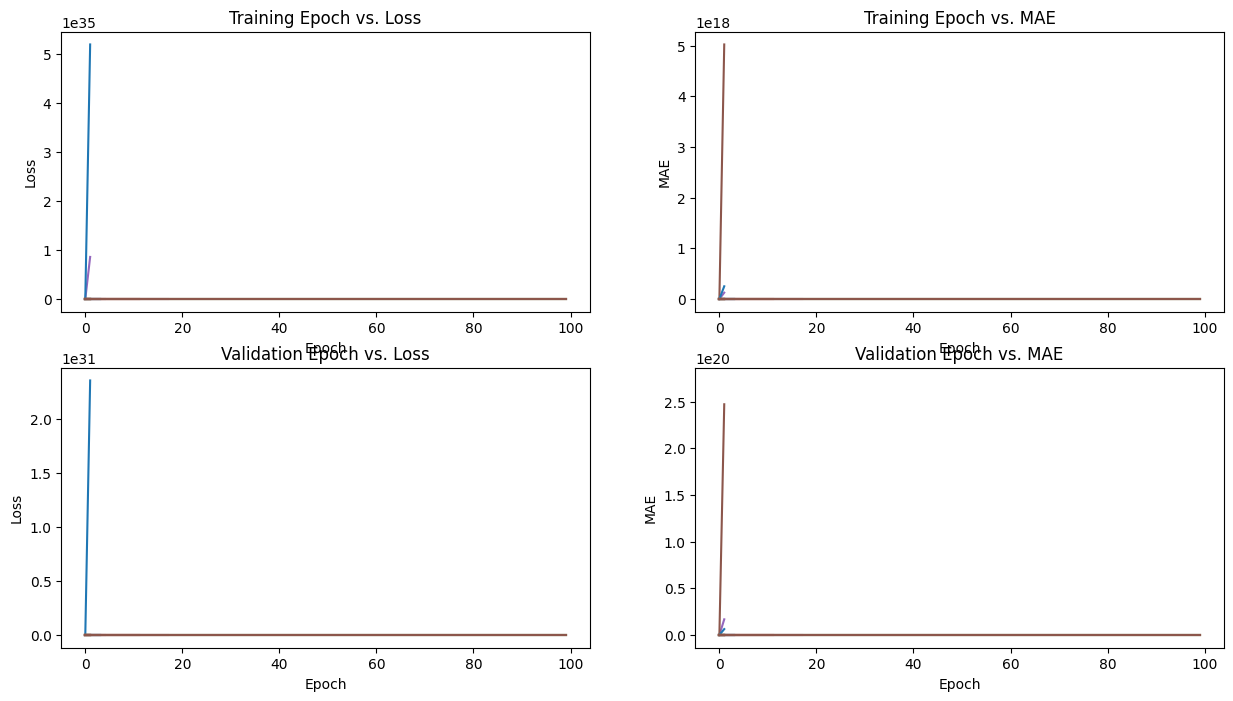

The best loss value that was found was nan
Config: learning rate = 0.2, batch size = 8
Loss on test set: nan
MAE on test set: nan


In [14]:
best_learning_rate = 0.0

best_batch_size = 0

current_optimized_loss = -1.0

current_optimized_network = None

fig, ax = plt.subplots(2,2, figsize=(15, 8))

for search_learning_rate in learning_rates:
    for search_batch_size in batch_sizes:
        torch.manual_seed(0)

        layer_one_size = health_train_data.shape[1] * 10
        layer_two_size = layer_one_size * 2

        health_neural_net = torch.nn.Sequential(
            torch.nn.Linear(health_train_data.shape[1], layer_one_size),
            torch.nn.Tanh(),
            torch.nn.Linear(layer_one_size, layer_two_size),
            torch.nn.Tanh(),
            torch.nn.Linear(layer_two_size, layer_two_size),
            torch.nn.Tanh(),
            torch.nn.Linear(layer_two_size, layer_one_size),
            torch.nn.Tanh(),
            torch.nn.Linear(layer_one_size, 1),
        )
        health_neural_net.to(device=device)

        sgd_optimizer = torch.optim.SGD(health_neural_net.parameters(), search_learning_rate)

        training_losses = []
            
        training_maes = []

        validation_losses = []
        
        validation_maes = []

        num_batches = math.ceil(len(health_train_data) / search_batch_size)

        for epoch in range(health_num_epochs):
            health_neural_net.train()

            train_loss_tot = 0.0
            
            train_mae_tot = 0.0

            for i in range(0, health_train_data.shape[0], search_batch_size):
                X_data_matrix = health_train_data[i:i+search_batch_size].to(device=device)
                y_value_vector = health_train_target[i:i+search_batch_size].to(device=device)

                sgd_optimizer.zero_grad()

                predictions = health_neural_net(X_data_matrix)
                loss = torch.nn.functional.mse_loss(predictions.view(-1), y_value_vector)
                loss.backward()

                sgd_optimizer.step()

                train_loss_tot += loss.item()
                
                train_mae_tot += torch.nn.functional.l1_loss(predictions.view(-1), y_value_vector).item()

            training_losses.append(train_loss_tot / num_batches)
            
            training_maes.append(train_mae_tot / num_batches)

            health_neural_net.eval()

            val_predictions = health_neural_net(health_val_data.to(device=device))
            val_mse_loss = torch.nn.functional.mse_loss(val_predictions.view(-1), health_val_target.to(device=device))
            validation_losses.append(val_mse_loss.item())

            val_mae_loss = torch.nn.functional.l1_loss(val_predictions.view(-1), health_val_target.to(device=device)).item()
            validation_maes.append(val_mae_loss)

            if validation_losses[epoch - 1] < validation_losses[epoch]:
                if validation_losses[epoch - 1] < current_optimized_loss or current_optimized_loss < 0.0:
                    current_optimized_loss = validation_losses[epoch - 1]

                    current_optimized_network = health_neural_net

                    best_learning_rate = search_learning_rate

                    best_batch_size = search_batch_size

                break
            else:
                if validation_losses[epoch] < current_optimized_loss or current_optimized_loss < 0.0:
                    current_optimized_loss = validation_losses[epoch]

                    current_optimized_network = health_neural_net

                    best_learning_rate = search_learning_rate

                    best_batch_size = search_batch_size

        ax[0,0].plot(numpy.arange(len(training_losses)), training_losses)
        ax[0,0].set_xlabel("Epoch")
        ax[0,0].set_ylabel("Loss")
        ax[0,0].set_title(f"Training Epoch vs. Loss")
        ax[0,0].grid()
        
        ax[0,1].plot(numpy.arange(len(training_maes)), training_maes)
        ax[0,1].set_xlabel("Epoch")
        ax[0,1].set_ylabel("MAE")
        ax[0,1].set_title(f"Training Epoch vs. MAE")
        ax[0,1].grid()
        
        ax[1,0].plot(numpy.arange(len(validation_losses)), validation_losses)
        ax[1,0].set_xlabel("Epoch")
        ax[1,0].set_ylabel("Loss")
        ax[1,0].set_title(f"Validation Epoch vs. Loss")
        ax[1,0].grid()
        
        ax[1,1].plot(numpy.arange(len(validation_maes)), validation_maes)
        ax[1,1].set_xlabel("Epoch")
        ax[1,1].set_ylabel("MAE")
        ax[1,1].set_title(f"Validation Epoch vs. MAE")
        ax[1,1].grid()

        training_losses.clear()
        
        training_maes.clear()
        
        validation_losses.clear()
        
        validation_maes.clear()

plt.show()

print(f"The best loss value that was found was {current_optimized_loss:.2f}\nConfig: learning rate = {best_learning_rate}, batch size = {best_batch_size}")

current_optimized_network.eval()

test_predictions = current_optimized_network(health_test_data.to(device=device))
test_mse_loss = torch.nn.functional.mse_loss(test_predictions.view(-1), health_test_target.to(device=device)).item()

test_mae_loss = torch.nn.functional.l1_loss(test_predictions.view(-1), health_test_target.to(device=device)).item()

print(f"Loss on test set: {test_mse_loss:.2f}")

print(f"MAE on test set: {test_mae_loss:.2f}")

## Question 3
### Develop a neural network using PyTorch for lung cancer prediction. Given information about the patient, such as their sex, age, allergies, etc, your model should predict whether or not they have lung cancer. You can use this dataset to train your model.

#### a) Load and split your dataset into train and test sets with a 7:3 ratio using methods from PyTorch.

In [2]:
lung_cancer_dataset = pandas.read_csv("lung cancer dataset(survey lung cancer).csv")
lung_cancer_dataset.loc[lung_cancer_dataset['GENDER'] == "M", 'GENDER'] = 1
lung_cancer_dataset.loc[lung_cancer_dataset['GENDER'] == "F", 'GENDER'] = 2
lung_cancer_dataset.loc[lung_cancer_dataset['LUNG_CANCER'] == "YES", 'LUNG_CANCER'] = 1
lung_cancer_dataset.loc[lung_cancer_dataset['LUNG_CANCER'] == "NO", 'LUNG_CANCER'] = 0
lung_cancer_dataset = lung_cancer_dataset.astype(float)

cancer_train_data, cancer_test_data, cancer_train_target, cancer_test_target = train_test_split(lung_cancer_dataset.loc[:, lung_cancer_dataset.columns != 'LUNG_CANCER'].to_numpy(),
                                                                                                lung_cancer_dataset.LUNG_CANCER.to_numpy(),
                                                                                                test_size=0.3,
                                                                                                random_state=42)

cancer_train_data = torch.tensor(cancer_train_data, dtype=torch.float32)
cancer_test_data = torch.tensor(cancer_test_data, dtype=torch.float32)
cancer_train_target = torch.tensor(cancer_train_target, dtype=torch.float32)
cancer_test_target = torch.tensor(cancer_test_target, dtype=torch.float32)

#### b) Implement and train your neural network. Note and plot the performance in terms of batch vs loss/accuracy across 100 epochs.

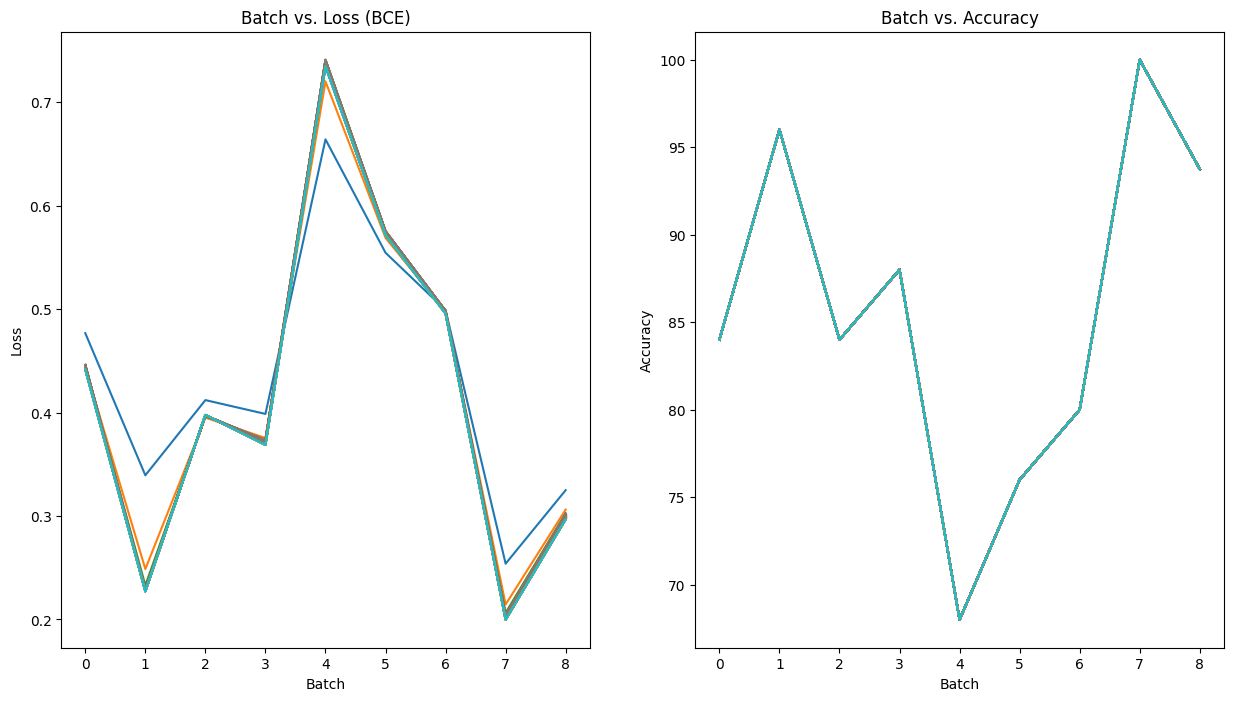

In [3]:
torch.manual_seed(0)

cancer_layer_one_size = cancer_train_data.shape[1]
cancer_layer_two_size = 10
cancer_layer_three_size = 5

cancer_neural_net = torch.nn.Sequential(
    torch.nn.Linear(cancer_layer_one_size, cancer_layer_one_size),
    torch.nn.ReLU(),
    torch.nn.Linear(cancer_layer_one_size, cancer_layer_two_size),
    torch.nn.ReLU(),
    torch.nn.Linear(cancer_layer_two_size, cancer_layer_three_size),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(cancer_layer_three_size, 1)
)
cancer_neural_net.train()

cancer_num_epochs = 100

cancer_batch_size = 25

cancer_learning_rate = 0.01

cancer_loss = torch.nn.BCELoss(reduction="mean")

cancer_optimizer = torch.optim.SGD(cancer_neural_net.parameters(), lr=cancer_learning_rate)

cancer_training_losses = []

cancer_training_accuracies = []

fig, (loss_ax, acc_ax) = plt.subplots(1,2, figsize=(15, 8))

for epoch in range(cancer_num_epochs):
    for i in range(0, len(cancer_train_data), cancer_batch_size):
        X_data = cancer_train_data[i:i+cancer_batch_size]

        y_value = cancer_train_target[i:i+cancer_batch_size]

        cancer_optimizer.zero_grad()

        class_predictions = torch.nn.functional.sigmoid(cancer_neural_net(X_data).view(-1))
        loss = cancer_loss(class_predictions, y_value)
        loss.backward()

        cancer_optimizer.step()

        cancer_training_losses.append(loss.item())

        cancer_training_accuracies.append(((torch.where(class_predictions >= 0.5, 1, 0) == y_value).sum() / len(y_value)).item() * 100)

    loss_ax.plot(numpy.arange(len(cancer_training_losses)), cancer_training_losses, label=f"Epoch {epoch}")
    loss_ax.set_xlabel("Batch")
    loss_ax.set_ylabel("Loss")
    loss_ax.set_title(f"Batch vs. Loss (BCE)")
    loss_ax.grid()

    acc_ax.plot(numpy.arange(len(cancer_training_accuracies)), cancer_training_accuracies, label=f"Epoch {epoch}")
    acc_ax.set_xlabel("Batch")
    acc_ax.set_ylabel("Accuracy")
    acc_ax.set_title(f"Batch vs. Accuracy")
    acc_ax.grid()

    cancer_training_losses.clear()

    cancer_training_accuracies.clear()

plt.show()

#### c) Analyze the performance on the test set using common classification metrics.

In [4]:
cancer_neural_net.eval()

cancer_test_predictions = torch.nn.functional.sigmoid(cancer_neural_net(cancer_test_data)).view(-1)
cancer_test_loss = cancer_loss(cancer_test_predictions, cancer_test_target)

cancer_test_accuracy = ((torch.where(cancer_test_predictions >= 0.5, 1, 0) == cancer_test_target).sum() / len(cancer_test_target)).item() * 100

print(f"Test loss: {cancer_test_loss:.2f}\nTest accuracy: {cancer_test_accuracy:.2f}%")

Test loss: 0.28
Test accuracy: 92.47%


#### d) It is time to fine-tune your model with the aim of enhancing its performance. Implement a grid search considering the learning rate and batch size parameters. Try variations of learning rates (i.e. 0.1, 0.01, 0.001, 0.0001, etc) and batch sizes (8, 16, 32, 64, etc). Compare the results in terms of training curves and testing performance.

In [5]:
learning_rates = [0.2, 0.1, .05, .025, 0.01, 0.001]

batch_sizes = [2**i for i in range(3, 9)]

cancer_train_data, cancer_val_data, cancer_train_target, cancer_val_target = train_test_split(cancer_train_data,
                                                                                                cancer_train_target,
                                                                                                test_size=0.2,
                                                                                                random_state=42)

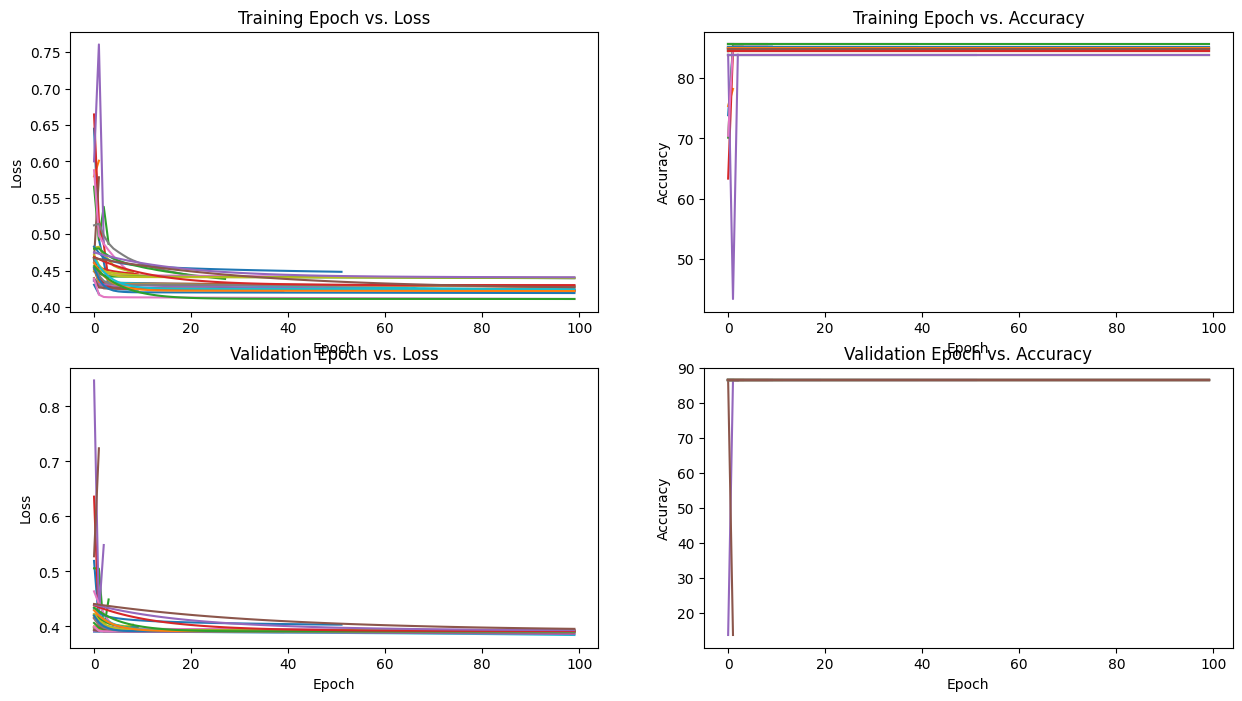

The best loss value that was found was 0.38
Config: learning rate = 0.025, batch size = 16
Loss on test set: 0.28
Accuracy on test set: 92.47%


In [9]:
best_learning_rate = 0.0

best_batch_size = 0

current_optimized_loss = 9999999.99

current_optimized_network = None

fig, ax = plt.subplots(2,2, figsize=(15, 8))

for search_learning_rate in learning_rates:
    for search_batch_size in batch_sizes:
        torch.manual_seed(0)

        cancer_layer_one_size = cancer_train_data.shape[1]
        cancer_layer_two_size = 10
        cancer_layer_three_size = 5

        cancer_neural_net = torch.nn.Sequential(
            torch.nn.Linear(cancer_layer_one_size, cancer_layer_one_size),
            torch.nn.ReLU(),
            torch.nn.Linear(cancer_layer_one_size, cancer_layer_two_size),
            torch.nn.ReLU(),
            torch.nn.Linear(cancer_layer_two_size, cancer_layer_three_size),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(cancer_layer_three_size, 1)
        )

        sgd_optimizer = torch.optim.SGD(cancer_neural_net.parameters(), search_learning_rate)

        training_losses = []
            
        training_accuracies = []

        validation_losses = []
        
        validation_accuracies = []

        num_batches = math.ceil(len(cancer_train_data) / search_batch_size)

        for epoch in range(cancer_num_epochs):
            cancer_neural_net.train()

            train_loss_tot = 0.0
            
            train_acc_tot = 0.0

            for i in range(0, cancer_train_data.shape[0], search_batch_size):
                X_data_matrix = cancer_train_data[i:i+search_batch_size]
                y_label_vector = cancer_train_target[i:i+search_batch_size]

                sgd_optimizer.zero_grad()

                class_predictions = torch.nn.functional.sigmoid(cancer_neural_net(X_data_matrix).view(-1))
                loss = cancer_loss(class_predictions, y_label_vector)
                loss.backward()

                sgd_optimizer.step()

                train_loss_tot += loss.item()
                
                train_acc_tot += ((torch.where(class_predictions >= 0.5, 1, 0) == y_label_vector).sum() / len(y_label_vector)).item() * 100

            training_losses.append(train_loss_tot / num_batches)
            
            training_accuracies.append(train_acc_tot / num_batches)

            cancer_neural_net.eval()

            val_conf_scores = torch.nn.functional.sigmoid(cancer_neural_net(cancer_val_data).view(-1))
            val_loss = cancer_loss(val_conf_scores, cancer_val_target)
            validation_losses.append(val_loss.item())

            validation_accuracies.append(((torch.where(val_conf_scores >= 0.5, 1, 0) == cancer_val_target).sum() / len(cancer_val_target)).item() * 100)

            if validation_losses[epoch - 1] < validation_losses[epoch]:
                if validation_losses[epoch - 1] < current_optimized_loss:
                    current_optimized_loss = validation_losses[epoch - 1]

                    current_optimized_network = cancer_neural_net

                    best_learning_rate = search_learning_rate

                    best_batch_size = search_batch_size

                break
            else:
                if validation_losses[epoch] < current_optimized_loss:
                    current_optimized_loss = validation_losses[epoch]
                    
                    current_optimized_network = cancer_neural_net

                    best_learning_rate = search_learning_rate

                    best_batch_size = search_batch_size

        ax[0,0].plot(numpy.arange(len(training_losses)), training_losses)
        ax[0,0].set_xlabel("Epoch")
        ax[0,0].set_ylabel("Loss")
        ax[0,0].set_title(f"Training Epoch vs. Loss")
        ax[0,0].grid()
        
        ax[0,1].plot(numpy.arange(len(training_accuracies)), training_accuracies)
        ax[0,1].set_xlabel("Epoch")
        ax[0,1].set_ylabel("Accuracy")
        ax[0,1].set_title(f"Training Epoch vs. Accuracy")
        ax[0,1].grid()
        
        ax[1,0].plot(numpy.arange(len(validation_losses)), validation_losses)
        ax[1,0].set_xlabel("Epoch")
        ax[1,0].set_ylabel("Loss")
        ax[1,0].set_title(f"Validation Epoch vs. Loss")
        ax[1,0].grid()
        
        ax[1,1].plot(numpy.arange(len(validation_accuracies)), validation_accuracies)
        ax[1,1].set_xlabel("Epoch")
        ax[1,1].set_ylabel("Accuracy")
        ax[1,1].set_title(f"Validation Epoch vs. Accuracy")
        ax[1,1].grid()

        training_losses.clear()
        
        training_accuracies.clear()
        
        validation_losses.clear()
        
        validation_accuracies.clear()

plt.show()

print(f"The best loss value that was found was {current_optimized_loss:.2f}\nConfig: learning rate = {best_learning_rate}, batch size = {best_batch_size}")

current_optimized_network.eval()

test_conf_scores = torch.nn.functional.sigmoid(current_optimized_network(cancer_test_data).view(-1))
test_loss = cancer_loss(test_conf_scores, cancer_test_target)

test_acc = ((torch.where(test_conf_scores >= 0.5, 1, 0) == cancer_test_target).sum() / len(cancer_test_target)).item() * 100

print(f"Loss on test set: {test_loss:.2f}")

print(f"Accuracy on test set: {test_acc:.2f}%")